In [43]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image

from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.preprocessing import image

In [23]:
# Dataset paths
TRAIN_DIR = '../dataset/train'
VAL_DIR = '../dataset/validation'
TEST_DIR = '../dataset/test'

In [24]:
# Image Parameters
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224

# Dataset Preprocessing

In [25]:
dataRescale = ImageDataGenerator(rescale=1./255)
dataAugment = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

### Load and apply preprocessing

In [26]:
train_dataset_gen = dataRescale.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_dataset_gen = dataRescale.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_dataset_gen = dataRescale.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
)

# Augment train dataset
train_augmented = dataAugment.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 1500 images belonging to 15 classes.
Found 300 images belonging to 15 classes.
Found 318 images belonging to 15 classes.
Found 1500 images belonging to 15 classes.


### Convert ImageDataGenerator to tf.data.Dataset

In [27]:
def generator_to_tf_dataset(generator):
    return tf.data.Dataset.from_generator(
        lambda: (generator[i] for i in range(len(generator))),
        output_types=(tf.float32, tf.float32),  # (images, labels)
        output_shapes=(
            (BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, 3),  # Shape of images
            (BATCH_SIZE, len(generator.class_indices))  # Shape of labels
        )
    )

In [28]:
train_dataset_augmented = generator_to_tf_dataset(train_augmented)
train_dataset = generator_to_tf_dataset(train_dataset_gen)
val_dataset = generator_to_tf_dataset(val_dataset_gen)
test_dataset = generator_to_tf_dataset(test_dataset_gen)

In [49]:
train_dataset = train_dataset.concatenate(train_dataset_augmented)

# Prefetch
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

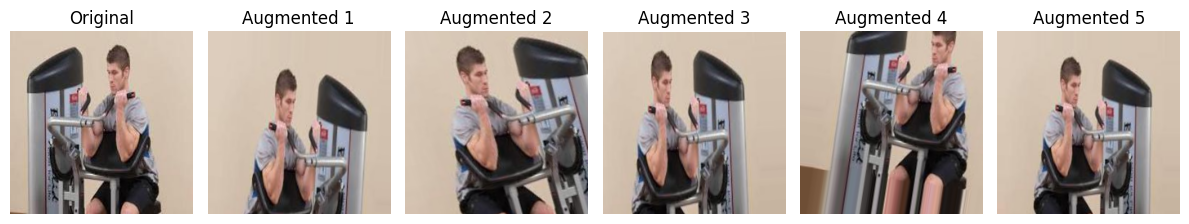

In [48]:

image = load_img('../dataset/train/Arm Curl Machine/-0001_jpg.rf.eb14b7672e2736671fef15fd02be77e9.jpg', target_size=(IMG_HEIGHT, IMG_WIDTH))
image_array = img_to_array(image)
plt.figure(figsize=(12, 6))

# Show the original image
plt.subplot(1, 6, 1)
plt.imshow(image_array.astype('uint8'))
plt.title("Original")
plt.axis('off')

# Prepare the image for augmentation
image_array = np.expand_dims(image_array, axis=0)

# Generate augmented images
augmented_images = dataAugment.flow(image_array, batch_size=1)

# Plot augmented images
for i in range(5):
    augmented_image_array = next(augmented_images)[0]
    augmented_image_array = np.clip(augmented_image_array, 0, 1)  # Ensure values stay in range
    plt.subplot(1, 6, i + 2)
    plt.imshow(augmented_image_array)
    plt.title(f"Augmented {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Modeling

In [23]:
# load Pre-Trained MobileNetV2
base_model = tf.keras.applications.MobileNetV2(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
base_model.summary(show_trainable=True, expand_nested=True)

Model: "mobilenetv2_1.00_224"
_____________________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     Trainable  
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               Y          
                                )]                                                                           
                                                                                                             
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_6[0][0]']                Y          
                                )                                                                            
                                                                                                             
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']          

## Fine Tuning

In [33]:
# Freeze Selected Layer
freeze_to_layer = len(base_model.layers)
for layer in base_model.layers[:freeze_to_layer]:
      layer.trainable = False

In [34]:
def custom_model():
    
    input_layer = tf.keras.Input(shape=(224, 224, 3))
    x = base_model(input_layer, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024, activation=tf.nn.relu)(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(512, activation=tf.nn.relu)(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    output_layer = tf.keras.layers.Dense(15, activation=tf.nn.softmax)(x)
    
    # declare inputs and outputs
    cust_model = Model(inputs=input_layer, outputs=output_layer)
    
    return cust_model

In [35]:
model_ft = custom_model()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

model_ft.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model_ft.fit(train_dataset, validation_data=val_dataset, epochs=100)

Epoch 1/100
75/75 [==============================] - 11s 90ms/step - loss: 2.9354 - accuracy: 0.0780 - val_loss: 2.7046 - val_accuracy: 0.0667
Epoch 2/100
75/75 [==============================] - 7s 81ms/step - loss: 2.7881 - accuracy: 0.1093 - val_loss: 2.6338 - val_accuracy: 0.1200
Epoch 3/100
75/75 [==============================] - 7s 88ms/step - loss: 2.6968 - accuracy: 0.1207 - val_loss: 2.5738 - val_accuracy: 0.1733
Epoch 4/100
75/75 [==============================] - 7s 85ms/step - loss: 2.5830 - accuracy: 0.1700 - val_loss: 2.5171 - val_accuracy: 0.2100
Epoch 5/100
75/75 [==============================] - 7s 82ms/step - loss: 2.5263 - accuracy: 0.1873 - val_loss: 2.4654 - val_accuracy: 0.2533
Epoch 6/100
75/75 [==============================] - 7s 86ms/step - loss: 2.4651 - accuracy: 0.2213 - val_loss: 2.4154 - val_accuracy: 0.2833
Epoch 7/100
75/75 [==============================] - 7s 84ms/step - loss: 2.3403 - accuracy: 0.2527 - val_loss: 2.3650 - val_accuracy: 0.3100
Epoch

In [36]:
model_ft.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_5   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_15 (Dense)            (None, 1024)              1311744   
                                                                 
 dropout_10 (Dropout)        (None, 1024)              0         
                                                                 
 dense_16 (Dense)            (None, 512)               5248

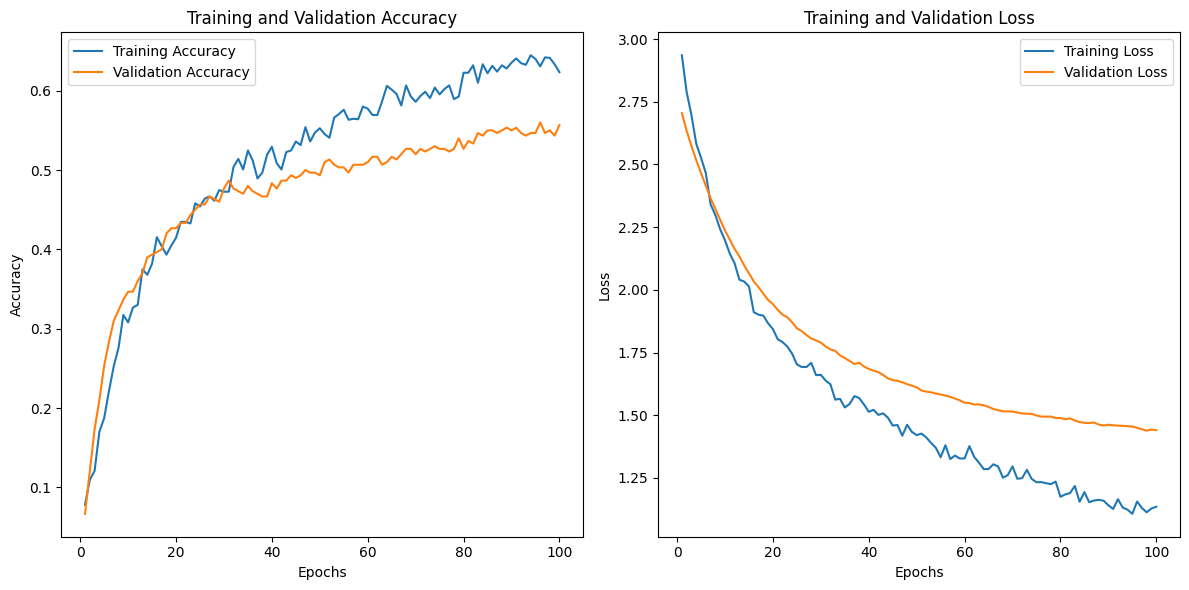

In [37]:
# Extracting data from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Defining the number of epochs
epochs = range(1, len(acc) + 1)

# Plotting Training and Validation Accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()